# Open Set Emotion Recognition

## Library Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%matplotlib inline
from collections import Counter, defaultdict
import torch.nn as nn
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
tqdm.pandas()
from tqdm import tqdm
import librosa
import re
from collections import Counter
import torch
from torchvision import models, transforms
from PIL import Image
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,f1_score

from sentence_transformers import SentenceTransformer

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cuda


In [2]:
OTHER_LABEL = 6

## Dataset Creation

### MELD

In [3]:
# class MELDDataset(Dataset):
#     def __init__(self, meld_dir, split, transform=None):
#         train_df = pd.read_csv("../MELD_Dataset/train_sent_emo.csv")
#         labels = train_df['Emotion'].unique().tolist()
#         self.label_to_int = {label: i for i, label in enumerate(labels)}

#         self.meld_dir = meld_dir
#         self.transform = transform
#         self.split = split
#         self.img_path = os.path.join(self.meld_dir, 'mel_spectrograms', f'{self.split}_img')
#         self.img_path = os.path.join(self.meld_dir, 'log_spectrogram', f'{self.split}_audio')

#         # load and create sentence embeddings
#         self.dialogues = self.load_dialogues()
#         self.sbert = SentenceTransformer('multi-qa-mpnet-base-dot-v1', device=device)
#         sentences = self.dialogues['Utterance'].tolist()
#         sentences = [text.replace("\x92", "'") for text in sentences]
#         self.sentence_embeddings = self.sbert.encode(sentences, convert_to_tensor=True, show_progress_bar=True, batch_size=128, device=device)

#         self.spectrograms = self.load_spectrograms()
#         self.resnet_model = models.resnet50(pretrained=True)
#         self.feature_extractor = torch.nn.Sequential(*list(self.resnet_model.children())[:-1]).to(device)
#         self.feature_extractor.eval()

#     def load_dialogues(self):
#         dialogue_file = os.path.join(self.meld_dir, f'{self.split}_sent_emo.csv')
#         dialogues = pd.read_csv(dialogue_file)
#         return dialogues

#     def load_spectrograms(self):
#         images = os.listdir(self.img_path)
#         return images

#     def __len__(self):
#         assert(len(self.sentence_embeddings) == len(self.spectrograms))
#         return len(self.dialogues)

#     def preprocess_img(self, img):
#         preprocessor = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#         ])
#         img_t =  preprocessor(img).to(device)
#         return img_t

#     def extract_audio_features_from_spectrogram(self, img):
#         # Pass the input through the model
#         with torch.no_grad():
#             output = self.feature_extractor(img)
#         return output

#     def __getitem__(self, idx):
#         row = self.dialogues.iloc[idx]
#         text = self.sentence_embeddings[idx]
#         spectrogram_data = Image.open(os.path.join(self.img_path, f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}.png'))
#         spectrogram_data = self.preprocess_img(spectrogram_data)
#         spectrogram_data = spectrogram_data[0:3, :, :]
#         spectrogram_data = spectrogram_data.unsqueeze(0)
#         spectrogram_data = self.extract_audio_features_from_spectrogram(spectrogram_data)
#         spectrogram_data = spectrogram_data.view(-1, 2048)[0]
#         label = row['Emotion']
#         label = torch.tensor(self.label_to_int[label])
#         return text, spectrogram_data, label

# train_meld = MELDDataset("../MELD_Dataset", "train")
# # test_meld = MELDDataset("../MELD_Dataset", "test")
# # dev_meld = MELDDataset("../MELD_Dataset", "dev")

# # concat all 3 datasets into 1 dataset
# meld_dataset = train_meld # + test_meld + dev_meld

In [4]:
# len(meld_dataset)

#### IEMOCAP

In [5]:
class IemocapDataset(Dataset):
    def __init__(self, iemocap_dataset_full_path, iemocap_spectrogram_dir, iemocap_log_spectrogram_dir, is_closed_label_set_flag, labels_to_int, split, transform=None):
        self.IEMOCAP_MAIN_FOLDER = os.path.join(iemocap_dataset_full_path,"IEMOCAP_full_release")
        self.TRANSCRIPTION_FOLDER = os.path.join("dialog", "transcriptions")
        self.AUDIO_FOLDER = os.path.join("sentences", "wav")
        self.CATEGORICAL_LABELS_PATH = os.path.join("dialog", "EmoEvaluation", "Categorical")
        self.split = split
        self.transform = transform
        self.is_closed_label_set_flag = is_closed_label_set_flag
        self.iemocap_spectrogram_dir = iemocap_spectrogram_dir
        self.iemocap_log_spectrogram_dir = iemocap_log_spectrogram_dir
        
        self.errors = defaultdict(int)
        self.unique_labels = []
        self.audio_files = []
        self.sentences_list = []
        self.dataset = self.create_dataset()
        self.labels_to_int = labels_to_int

        self.sbert = SentenceTransformer('multi-qa-mpnet-base-dot-v1', device=device)
        self.sentence_embeddings = self.sbert.encode(self.sentences_list, convert_to_tensor=True, show_progress_bar=True, batch_size=128, device=device)
        
        self.create_spectrograms(self.iemocap_spectrogram_dir)
        self.create_log_spectrograms(self.iemocap_log_spectrogram_dir)
        self.print_summary()

        self.resnet_model = models.resnet50(pretrained=True)
        self.feature_extractor = torch.nn.Sequential(*list(self.resnet_model.children())[:-1]).to(device)
        self.feature_extractor.eval()
        
    def get_evaluator_filenames_with_video_file_prefix(self, input_list, prefix_value):
        regex_pattern = re.compile(f'^{re.escape(prefix_value)}.*\.txt$')
        matching_strings = [s for s in input_list if regex_pattern.match(s)]
        return matching_strings
    
    def get_utterance_to_evaluationCounter_mapping_from_evaluation_files(self, evaluation_files):
        utterance_to_all_evaluations = {}

        for evaluation_file in evaluation_files:
            utterance_to_evaluationList = {}
            with open(evaluation_file,'r') as f:
                contents = f.read()
                utterance_evaluations = contents.split("\n")
                for evaluation in utterance_evaluations:
                    evaluation = evaluation.strip()
                    if(len(evaluation)==0):
                        continue
                    matches = re.findall(r':[^;]+;', evaluation)
                    matches = [match[1:-1] for match in matches]
                    utterance_to_evaluationList[evaluation.split()[0]] = matches
            
            # Combine lists from dict1
            for key, value_list in utterance_to_evaluationList.items():
                utterance_to_all_evaluations[key] = utterance_to_all_evaluations.get(key, []) + value_list

        utterance_to_evaluationsCounter = {k:Counter(v).most_common(1)[0][0] for k,v in utterance_to_all_evaluations.items()}
        return utterance_to_evaluationsCounter
    
    def is_label_a_closed_label(self,evaluation):
        return evaluation in ["Frustration","Excited","Neutral state","Anger","Sadness","Happiness"]
    
    def create_dataset(self):
        dataset = []
        for session_num in range(1,6):
            for transcription_filename in os.listdir(os.path.join(self.IEMOCAP_MAIN_FOLDER,f"Session{session_num}", self.TRANSCRIPTION_FOLDER)):
                if(transcription_filename[0]!="."): 

                    filename_without_extension = transcription_filename.split(".")[0]
                    
                    categorical_labels_folder_full_path = os.path.join(self.IEMOCAP_MAIN_FOLDER, f"Session{session_num}", self.CATEGORICAL_LABELS_PATH)
                    evaluation_filenames = self.get_evaluator_filenames_with_video_file_prefix(os.listdir(categorical_labels_folder_full_path), filename_without_extension)
                    evaluation_files_full_paths_for_this_file = [os.path.join(self.IEMOCAP_MAIN_FOLDER, f"Session{session_num}", self.CATEGORICAL_LABELS_PATH, f) for f in evaluation_filenames]
                    evaluations_per_utterance = self.get_utterance_to_evaluationCounter_mapping_from_evaluation_files(evaluation_files_full_paths_for_this_file)
                    
                    transcription_file_full_path = os.path.join(self.IEMOCAP_MAIN_FOLDER, f"Session{session_num}", self.TRANSCRIPTION_FOLDER, transcription_filename) 
                    with open(transcription_file_full_path,'r') as f:
                        contents = f.read()
                        lines = contents.split("\n")

                        # Iterate through utterances where every utterance looks like:
                        # Ses01F_impro01_F000 [006.2901-008.2357]: Excuse me.
                        for line in lines:

                            # Remove extra spaces and check if the line is not an empty link (usually at EOF)
                            line = line.strip()
                            if(len(line)==0):
                                break

                            # Remove idx of first space, ], -
                            try:
                                space_idx = line.index(" ")
                                timestampEndBracket_idx = line.index("]")
                                timestampHyphen_idx = line.index("-")
                            except:
                                self.errors["Problematic Transcription Line"]+=1
                                continue
                            else:
                                audio_filename = line[:space_idx]        # output audio file name = utterance name
                                text = line[timestampEndBracket_idx+3:]         # the transcription of the utterance
                                evaluation = evaluations_per_utterance.get(audio_filename,"KEY_ERROR")
                                if(evaluation=="KEY_ERROR"):
                                    self.errors["Unavailable Label for an utterance"]+=1

                                utterance_audios_per_video_folder = audio_filename[:line.rindex('_')]       # Only need Ses01F_impro01 from Ses01F_impro01_F000
                                audio_file_full_path = os.path.join(self.IEMOCAP_MAIN_FOLDER, f"Session{session_num}", self.AUDIO_FOLDER, utterance_audios_per_video_folder, audio_filename+".wav")         # name of the video file

                                if(evaluation!="KEY_ERROR" and os.path.isfile(audio_file_full_path)==True and self.is_label_a_closed_label(evaluation)==self.is_closed_label_set_flag):
                                # if(evaluation!="KEY_ERROR" and os.path.isfile(audio_file_full_path)==True):    
                                    self.audio_files.append(audio_file_full_path)
                                    self.sentences_list.append(text)
                                    dataset.append((text,audio_file_full_path,evaluation))
                                    if evaluation not in self.unique_labels:
                                        self.unique_labels.append(evaluation)
        return dataset
    
    def print_summary(self):
        print("SUMMARY:\n")
        for k,v in self.errors.items():
            print(f"{k}: {v}")
    
    def create_spectrograms(self,iemocap_spectrogram_dir):
        log_dir = os.path.join(os.path.dirname(os.getcwd()),'iemocap','log_dir')
        output_dir = os.path.join(os.path.dirname(os.getcwd()),iemocap_spectrogram_dir)
        log_file_path = os.path.join(log_dir,'processed_files_spectrogram.log')
        error_log_path = os.path.join(log_dir,'error_files_spectrogram.log')

        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        processed_files = set()
        if os.path.exists(log_file_path):
            with open(log_file_path, 'r') as file:
                processed_files = set(file.read().splitlines())

        processed_files_count = 0
        throttle_delay = 1 
        def create_spectrogram(filename, audio_file_path, output_file_path):
            y, sr = librosa.load(audio_file_path)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            S_dB = librosa.power_to_db(S, ref=np.max)
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(S_dB, sr=sr, fmax=8000)
            plt.tight_layout()
            plt.savefig(output_file_path)
            plt.close()

        for filenum in tqdm(range(len(self.audio_files))):
            filename = self.audio_files[filenum]
            if filename.endswith(".wav") and filename not in processed_files:

                audio_file_path = os.path.join(filename)
                output_file_path = os.path.join(output_dir, os.path.splitext(os.path.basename(filename))[0])
                try:
                    create_spectrogram(filename, audio_file_path, output_file_path)
                    processed_files.add(filename)
                    processed_files_count += 1
                    with open(log_file_path, 'a') as log_file:
                        log_file.write(f"{filename}\n")
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
                    with open(error_log_path, 'a') as error_log:
                        error_log.write(f"{filename}: {e}\n")
                finally:
                    time.sleep(throttle_delay)

        print(f"Batch conversion completed for spectrograms. Processed {processed_files_count} files.")

    
    def create_log_spectrograms(self,iemocap_log_spectrogram_dir):
        def log_specgram(audio, sample_rate, window_size=20,
                        step_size=10, eps=1e-10):
            nperseg = int(round(window_size * sample_rate / 1e3))
            noverlap = int(round(step_size * sample_rate / 1e3))
            freqs, times, spec = signal.spectrogram(audio, fs=sample_rate, window='hann', 
                                                    nperseg=nperseg, noverlap=noverlap, detrend=False)
            return freqs, np.log(spec.T.astype(np.float32) + eps)

        def process_audio_file(filepath, output_dir):
            sample_rate, audio = wavfile.read(filepath)
            if audio.ndim > 1:
                audio = audio.mean(axis=1)
            _, spectrogram = log_specgram(audio, sample_rate)
            plt.figure(figsize=(10, 4))  
            plt.xticks([])
            plt.yticks([])
            plt.imshow(spectrogram.T, aspect='auto', origin='lower')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, os.path.splitext(os.path.basename(filepath))[0]+".png"))
            plt.close()  

        log_dir = os.path.join(os.path.dirname(os.getcwd()),'iemocap','log_dir')
        output_dir = os.path.join(os.path.dirname(os.getcwd()),iemocap_log_spectrogram_dir)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        log_file_path = os.path.join(log_dir, 'processed_files_log_spectrogram.log')
        error_log_path = os.path.join(log_dir, 'error_files_log_spectrogram.log')

        throttle_delay = 1 

        processed_files = set()
        if os.path.exists(log_file_path):
            with open(log_file_path, 'r') as file:
                processed_files = set(file.read().splitlines())

        processed_files_count = 0
        for filenum in tqdm(range(len(self.audio_files))):
            filepath = self.audio_files[filenum]
            if filepath.endswith(".wav") and filepath not in processed_files:
                try:
                    process_audio_file(filepath, output_dir)
                    processed_files.add(filepath)
                    processed_files_count += 1
                    with open(log_file_path, 'a') as log_file:
                        log_file.write(f"{filepath}\n")
                except Exception as e:
                    print(f"Error processing {filepath}: {e}")
                    with open(error_log_path, 'a') as error_log:
                        error_log.write(f"{filepath}: {e}\n")
                finally:
                    time.sleep(throttle_delay)

        print(f"Batch conversion completed for log spectrograms. Processed {processed_files_count} files.")

    def preprocess_img(self, img):
        preprocessor = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        img_t =  preprocessor(img).to(device)
        return img_t

    def extract_audio_features_from_spectrogram(self, img):
        # Pass the input through the model
        with torch.no_grad():
            output = self.feature_extractor(img)
        return output
    
    def __len__(self):
        return len(self.dataset)
    
    from functools import lru_cache

    @lru_cache(maxsize=None)
    def cached_audio_features(self, img_path):
        spectrogram_data = Image.open(img_path)
        spectrogram_data = self.preprocess_img(spectrogram_data)
        spectrogram_data = spectrogram_data[0:3, :, :]
        spectrogram_data = spectrogram_data.unsqueeze(0)
        spectrogram_data = self.extract_audio_features_from_spectrogram(spectrogram_data)
        spectrogram_data = spectrogram_data.view(-1, 2048)[0]
        return spectrogram_data

    
    def __getitem__(self, idx):
        _, audio, label = self.dataset[idx]

        text = self.sentence_embeddings[idx]

        img_path = os.path.join(os.path.dirname(os.getcwd()),self.iemocap_spectrogram_dir,os.path.splitext(os.path.basename(audio))[0]+".png")
        spectrogram_data = self.cached_audio_features(img_path)

        if(self.is_closed_label_set_flag==False):
            label = OTHER_LABEL
        else:
            label = self.labels_to_int[label]

        if self.transform:
            audio = self.transform(audio)
        return text, spectrogram_data, label

In [6]:
IEMOCAP_FULL_PATH = os.path.join(os.path.dirname(os.getcwd()),"IEMOCAP_full_release")
labels_to_int = {'Neutral state': 0,
                'Frustration': 1,
                'Anger': 2,
                'Sadness': 3,
                'Happiness': 4,
                'Excited': 5,
                'Surprise': 6,
                'Fear': 7,
                'Other': 8,
                'Disgust': 9}

openIemocapDataset = IemocapDataset(iemocap_dataset_full_path=IEMOCAP_FULL_PATH,
                                iemocap_spectrogram_dir=os.path.join("iemocap","spectrogram"),
                                iemocap_log_spectrogram_dir=os.path.join("iemocap","log_spectrogram"),
                                is_closed_label_set_flag=False,
                                labels_to_int=labels_to_int,
                                split=None,
                                transform=None)
closedIemocapDataset = IemocapDataset(iemocap_dataset_full_path=IEMOCAP_FULL_PATH,
                                iemocap_spectrogram_dir=os.path.join("iemocap","spectrogram"),
                                iemocap_log_spectrogram_dir=os.path.join("iemocap","log_spectrogram"),
                                is_closed_label_set_flag=True,
                                labels_to_int=labels_to_int,
                                split=None,
                                transform=None)

100%|██████████| 245/245 [00:00<?, ?it/s]


Batch conversion completed for spectrograms. Processed 0 files.


100%|██████████| 245/245 [00:00<00:00, 245134.66it/s]


Batch conversion completed for log spectrograms. Processed 0 files.
SUMMARY:

Problematic Transcription Line: 152
Unavailable Label for an utterance: 48


100%|██████████| 9794/9794 [00:00<00:00, 1637201.12it/s]


Batch conversion completed for spectrograms. Processed 0 files.


100%|██████████| 9794/9794 [00:00<00:00, 1964281.23it/s]


Batch conversion completed for log spectrograms. Processed 0 files.
SUMMARY:

Problematic Transcription Line: 152
Unavailable Label for an utterance: 48


In [7]:
Counter([i[2] for i in closedIemocapDataset])

Counter({1: 2916, 5: 1976, 0: 1726, 2: 1269, 3: 1251, 4: 656})

In [8]:
len(openIemocapDataset)

245

In [9]:
len(closedIemocapDataset)

9794

In [10]:
def get_stratified_split(dataset, test_size):

    indices = list(range(len(dataset)))
    dataset_labels = [item[2] for item in dataset]
    stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

    # Get the indices for training and testing sets
    for train_idx, test_idx in stratified_splitter.split(indices, dataset_labels):
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)
    
    return train_dataset,test_dataset

In [11]:
train_dataset, temp_dataset = get_stratified_split(closedIemocapDataset,0.2)
val_dataset_1, test_dataset_1 = get_stratified_split(temp_dataset,0.5)
val_dataset_2, test_dataset_2 = get_stratified_split(openIemocapDataset,0.5)

In [12]:
val_dataset = val_dataset_1+val_dataset_2
test_dataset = test_dataset_1+test_dataset_2

## Model

In [126]:
class AudioTextEmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(AudioTextEmotionModel, self).__init__()
        # sequential model with 2 layers, followed by dropout and relu layers and output layer
        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )


    def forward(self, audio, text):
        combined = torch.cat([audio, text], axis=1)
        return self.fc(combined)


model = AudioTextEmotionModel(7)
model.to(device)


AudioTextEmotionModel(
  (fc): Sequential(
    (0): Linear(in_features=2816, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=7, bias=True)
  )
)

## Loss Function and Optimizer

In [127]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, momentum=0.9)

## Train!

In [128]:
# Create data loaders.
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
num_epochs = 100

In [129]:
def accuracy(dataloader, model):
    size = len(dataloader.dataset)
    total_correct = 0
    model.eval()
    for batch, (text, spectrogram_data, label) in enumerate(dataloader):
        text, spectrogram_data, label = text.to(device), spectrogram_data.to(device), label.to(device)

        # Compute prediction error
        pred = model(spectrogram_data, text)
        predicted = torch.argmax(pred,dim=1).cpu()
        actual = label.cpu()
        correct = predicted == actual
        total_correct += correct.sum().item()
    return total_correct/size

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (text, spectrogram_data, label) in enumerate(dataloader):
        text, spectrogram_data, label = text.to(device), spectrogram_data.to(device), label.to(device)

        # Compute prediction error
        pred = model(spectrogram_data, text)
        loss = loss_fn(pred, label)
        # acc = accuracy_score(torch.argmax(pred,dim=1).cpu(), label.cpu())
        # f1 = f1_score(torch.argmax(pred,dim=1).cpu(),label.cpu(),average="micro")

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(text)
            # print(f"loss: {loss:>7f}\t\tAccuracy: {acc:>7f}\t\tF1 Score: {f1:>7f}  [{current:>5d}/{size:>5d}]")
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    print(accuracy(train_dataloader,model))
    print(accuracy(test_dataloader,model))


Epoch 1
-------------------------------
loss: 1.949139  [   64/ 7835]
loss: 1.681185  [ 6464/ 7835]
0.4289725590299936
0.3372620126926564
Epoch 2
-------------------------------
loss: 1.426537  [   64/ 7835]
loss: 1.432059  [ 6464/ 7835]
0.4816847479259732
0.3644605621033545
Epoch 3
-------------------------------
loss: 1.362325  [   64/ 7835]
loss: 1.295874  [ 6464/ 7835]
0.5324824505424378
0.37262012692656393
Epoch 4
-------------------------------
loss: 1.237118  [   64/ 7835]
loss: 1.169162  [ 6464/ 7835]
0.5674537332482451
0.3825929283771532
Epoch 5
-------------------------------
loss: 1.169981  [   64/ 7835]
loss: 0.900950  [ 6464/ 7835]
0.6131461391193364
0.4016319129646419
Epoch 6
-------------------------------
loss: 0.940765  [   64/ 7835]
loss: 0.841339  [ 6464/ 7835]
0.6695596681557116
0.4215775158658205
Epoch 7
-------------------------------
loss: 0.749401  [   64/ 7835]
loss: 0.744649  [ 6464/ 7835]
0.6630504148053605
0.4016319129646419
Epoch 8
-------------------------

In [17]:
# all_labels = []
# for text, spectrogram_data, label in test_dataloader:
#     all_labels = all_labels + list(label)
#     print (len(all_labels))
#
# Counter(all_labels)


## Evaluation

In [95]:
def set_dropout_to_train(eval_model):
    for module in eval_model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

def predict(label, model, text, spectrogram_data, n_simulations=100, threshold=0.5, other_label=OTHER_LABEL):
    predictions = [torch.argmax(model(spectrogram_data, text), dim=1).float() for _ in range(n_simulations)]
    predictions = torch.stack(predictions)

    # Calculate mode values along axis 0
    mode_values, _ = torch.mode(predictions, dim=0)

    # Calculate the count of each mode value
    mode_counts = torch.zeros_like(mode_values)
    for i, mode_val in enumerate(mode_values):
        mode_counts[i] = torch.sum(predictions[:, i] == mode_val)

    mode_values[mode_counts <= threshold*n_simulations] = other_label
    actual_other_label = 0
    correct_pred_of_other_label = 0
    for i in range(len(label)):
        l = label[i]
        if l==other_label:
            actual_other_label+=1
            if mode_values[i]==6:
                correct_pred_of_other_label+=1
    
    return mode_values, correct_pred_of_other_label, actual_other_label

def evaluate(model, dataloader, device, threshold=0.6):
    # After setting the model to evaluation mode, call this function
    model.eval()
    set_dropout_to_train(model)

    size = len(dataloader.dataset)
    total_correct = 0
    total_correct_pred_of_other_label, total_actual_other_label = 0,0
    for batch, (text, spectrogram_data, label) in enumerate(dataloader):
        text, spectrogram_data, label = text.to(device), spectrogram_data.to(device), label.to(device)

        predicted, correct_pred_other_label_for_this_batch, actual_other_label_for_this_batch = predict(label, model, text, spectrogram_data, threshold=threshold)
        predicted = predicted.cpu()
        actual = label.cpu()
        correct = predicted == actual
        total_correct += correct.sum().item()
        total_correct_pred_of_other_label+=correct_pred_other_label_for_this_batch
        total_actual_other_label+=actual_other_label_for_this_batch

    return total_correct/size, total_correct_pred_of_other_label/total_actual_other_label


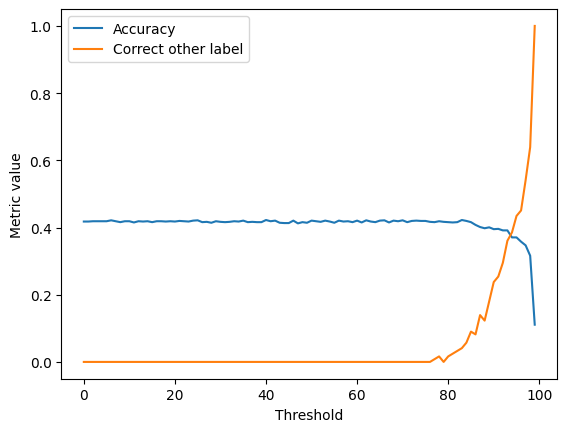

In [96]:
model_accuracy, correct_other_labels = [],[]
for threshold_val in np.logspace(-2,0,100,endpoint=True):
    model_accuracy_for_this_threshold, correct_other_label_for_this_threshold = evaluate(model,val_dataloader,device,threshold=threshold_val)
    model_accuracy.append(model_accuracy_for_this_threshold)
    correct_other_labels.append(correct_other_label_for_this_threshold)

plt.plot(range(len(model_accuracy)),model_accuracy,label="Accuracy")
plt.plot(range(len(correct_other_labels)),correct_other_labels,label="Correct other label")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.legend()
plt.show()

In [130]:
evaluate(model,test_dataloader,device,0.85)

(0.3563009972801451, 0.42276422764227645)

In [34]:
# learn pytorch basic with some basic models and datasets
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
# https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
# https://pytorch.org/tutorials/beginner/basics/nnqs_tutorial.html